### This notebook will walk you through how to build a lipid bilayer with OpenFF

In [ ]:
# Import all dependencies 

# from io import StringIO
# from typing import Iterable
import numpy as np
# import matplotlib.pyplot as plt

# from rdkit import Chem
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from openff.toolkit import ForceField, Molecule, Topology
# from openff.toolkit.utils.toolkits import OpenEyeToolkitWrapper

from openff.units import Quantity, unit
# from openmm import unit as openmm_unit
from openff.interchange import Interchange
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper #assign charges with NAGL

import nglview
import mdtraj
import sys
import os
import shutil
from pathlib import Path

scripts_path = os.path.join(os.getcwd(), 'scripts')
sys.path.insert(0, scripts_path)

from pull import pullLipid
import BuildLipid
from saveLipids import saveInterchange, Lipid, calcLipidLength, saveLipidCsv
from packmol import _build_input_file, runPackmol

In [ ]:
from openff.nagl_models import list_available_nagl_models

list_available_nagl_models()

Available lipids are located in BuildLipid module, which constructs lipids in a modular fashion {sn1} + {hg} + {sn2}.
load_dataframe() to load in lipid library
list_available_lipids() will return a list of available headgroups, tailgroups, and sterols

In [ ]:
# load in openFF's library of lipids and return a list of availablee lipid headgroups,tailgroups, and sterols to choose from
df = BuildLipid.load_dataframe()
BuildLipid.list_available_lipids(df) 

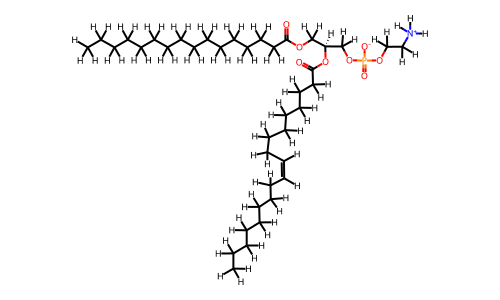

In [23]:
# Specify lipid you would like to parameterize "headgroup+tailgroup" or "sterol" (ex. 'POPC' or 'cholesterol') from the library of lipids
Lipid_name = 'POPE'
lipid_smiles, HG_pull_atom = BuildLipid.makeLipidSmiles(Lipid_name, df)


# if you want a lipid that is not yet supplied by the library, uncomment the 3 lines below and replace smiles string with your desired lipid,
# the pull atom with an atom in the headgroup, and the Lipid name with the common name or the lipid

# lipid_smiles = 'CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCCCCCC/C=C\CCCCCCCC'
# HG_pull_atom = 'N1x' #note that atom naming is openff format: atom type + atom number + x
# Lipid_name = 'POPC'


lipid = Molecule.from_smiles(lipid_smiles,allow_undefined_stereo=True)
lipid.generate_conformers()
lipid.visualize()

In [ ]:
lipid_smiles

In [ ]:
#parameterize lipid with openff interchange

# Assign partial charges via OpenFF NAGL
lipid.assign_partial_charges("openff-gnn-am1bcc-0.1.0-rc.3.pt", toolkit_registry=NAGLToolkitWrapper())
lipid.partial_charges


lipid.name = Lipid_name
for i, atom in enumerate(lipid.atoms, 0):
    atom.metadata["residue_name"] = Lipid_name
lipid.generate_unique_atom_names() 
topology = Topology.from_molecules([lipid])

# Specify forcefield
forcefield = ForceField("openff-2.2.0.offxml")

interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
    charge_from_molecules = [lipid]
)
interchange  

interchange.to_top(f"{Lipid_name}.top") #, decimal = 3, hydrogen_mass = 3) #for hygrogen mass repartitioning.. probably need another topology file filder for HMR
# or is there from grompp option to change topology file that can be used downstream?
interchange.to_gro(f"{Lipid_name}.gro")

In [ ]:
#build a water model and parameterize with openff interchange

water_model = 'TIP3P'
water = Molecule.from_smiles('O')
water.generate_conformers()
water.name = water_model

for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = water_model
water.generate_unique_atom_names() 
topology = Topology.from_molecules([water])


interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
)
interchange

# PDB structure for Packmol
interchange.to_pdb(f"{water_model}.pdb")
interchange.to_top(f"{water_model}.top")

In [ ]:
# the lipid is not in an optimal packing configuration, run code to "straighten out" lipid

pullLipid(f'{Lipid_name}',f'{Lipid_name}.gro', f'{Lipid_name}.top', HG_pull_atom)

In [ ]:
# save the pulled lipid pdb to folder, creates a folder for specific lipid if it doesnt already exist

file_paths = [f'{Lipid_name}.pdb', f'{Lipid_name}.top'] 
saveInterchange(Lipid_name, file_paths)

# once we have a large enough library of pulled lipids, we will no longer have to run pulling commmands for each lipid

### Use trjconv to produce a pdb of the lipid after pull code. Visualize with nglview to confirm 


In [ ]:
#visualize the pulled lipid using ngl view
view = nglview.show_structure_file(f'Dictionary/lipids_parameterized/{Lipid_name}/{Lipid_name}.pdb')
view


In [ ]:
# save the pulled lipid data to a csv. YOU WILL NEED TO MANUALLY FIND A TERMINAL ATOM IN THE LIPID TAIL (last carbon in sn1 or sn2)
lipid = Lipid(
    name=Lipid_name,
    headgroup_atom=HG_pull_atom,  
    headgroup_atom_index=None, 
    tailgroup_atom='C42x',  # this needs to be changed for every simulation
    tailgroup_atom_index=None,
    distance=None,  
    experimental_density=None  # Example value in g/cm^3, not necessary but may be helpful in the future?
)

# Calculate lipid length (distance between headgroup and tailgroup)
calcLipidLength(lipid, Lipid_name)

# Save the lipid to the CSV file with all its corresponding information
saveLipidCsv(lipid)

In [ ]:
####### 
# here is where once we have a full lipid library of multiple lipids, we can automate this in a read me and only rely on .py scripts

# 1. load in pdb files from library. can also load in topology files but these will become outdated with new sage versions
        # accept a list of lipids from prebuilt or smiles string and solvent ex. [POPC, smilestring, TIP3P]. ions added later
# 2. parameterize individual lipids 
# 3. pack lipid (multiple)

In [ ]:
# Now we want to specify the system we want to build with our lipid + water
# edit with how many TOTAL lipids you would like in your cubic box, and how many solvent molecules 
number_of_lipids = 128
number_of_solvent = 2560*2

# Create a packmol input file 
packmol_file_name, output_file_path, dims = _build_input_file(Lipid_name, number_of_lipids, 'TIP3P',number_of_solvent,2, 'PulledLipid.csv' )


In [ ]:
# A packmol_input.inp file has been created in the main directory
# To run: 

#consider adding runPackmol into _build_input_file (but first make sure it runs for all lipids)
runPackmol(packmol_file_name)


In [ ]:
#visualize with ngl view (make sure this works with output_file_path, may need to specify full path)
view = nglview.show_structure_file(output_file_path)
view

Now that you have a .pdb from packmol, parameterize the full system:

In [ ]:
topology = Topology.from_molecules(number_of_lipids * [lipid]+ number_of_solvent * [water])

# Packmol bilayer to parametrize
path = mdtraj.load(output_file_path)
topology.set_positions(path.xyz[0] * unit.nanometer)
topology.box_vectors =  np.array(dims)*0.1 * unit.nanometer #convert from angstoms (packmol default) to openff default nm

interchange = forcefield.create_interchange(topology)

interchange.to_gromacs(prefix = "bilayer")

In [ ]:
# Do you want to add ions?

# gmx grompp -f ions.mdp -c bilayer.gro -p topol.top -o ions.tpr
# gmx genion -s ions.tpr -o bilayer_ions.gro -p topol.top -pname NA -nname CL -neutral\

# When prompted, choose group TIP3P (group 2) for embedding ions. You do not want to replace parts of your protein with ions

Files are now ready to be run using Gromacs.

Min, NVT, NPT, MD production run

In [ ]:
# $ gmx grompp -f min.mdp -p topol.top -c bilayer.gro -o min.tpr
# $ gmx mdrun -deffnm min

# $ gmx grompp -p topol.top -f nvt.mdp -c min.gro -o nvt.tpr
# $ gmx mdrun -deffnm nvt

# $ gmx grompp -f npt.mdp -p topol.top -c nvt.gro -o npt.tpr -maxwarn 1
# $ gmx mdrun -deffnm npt

# $ gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr
# $ gmx mdrun -deffnm md
# # Checkpoint run for completion
# $ gmx mdrun -deffnm md -cpi md.cpt